# AI-Driven Market Trend Analysis & Forecasting System (Indian NSE)

**Project Summary:** Phase 2 focuses on a reproducible data pipeline and evaluator-ready EDA for the NIFTY 50 index. Forecasting models are introduced in Phase 3 for ARIMA and LSTM comparison.


## 1. Problem Definition & Objective
- Establish a clean, cached, and feature-enriched dataset for analysis.
- Produce rigorous EDA artifacts and insights for forecasting readiness.
- Compare two forecasting baselines (ARIMA vs. LSTM) on the same test set.


## 2. Data Understanding & Preparation
- Source: yfinance (NIFTY 50 symbol configurable in `src/config.py`).
- Target schema: `[Date, Open, High, Low, Close, Adj Close, Volume]`.
- Cache raw data with timestamps and persist cleaned + split datasets.


In [134]:
import sys
from pathlib import Path
import logging
import warnings

import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path.cwd()
if not (ROOT / "src").exists():
    for parent in ROOT.parents:
        if (parent / "src").exists():
            ROOT = parent
            break
# Colab-friendly fallbacks
colab_candidates = [
    Path('/content/market-trend-ai'),
    Path('/content/drive/MyDrive/market-trend-ai'),
]
for candidate in colab_candidates:
    if (candidate / 'src').exists():
        ROOT = candidate
        break
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.config import CONFIG
from src import data_loader, preprocess, features, viz, utils

warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.INFO)
utils.set_seeds(CONFIG.random_seed)

In [135]:
# Data acquisition with offline fallback
raw_df = data_loader.download_data(symbol=CONFIG.default_symbol)
raw_df.head()

2026-01-12 00:13:14,204 [WARNING] src.data_loader - yfinance not installed; falling back to synthetic data.
2026-01-12 00:13:14,205 [WARNING] src.data_loader - Falling back to synthetic data for symbol ^NSEI.
2026-01-12 00:13:14,205 [WARNING] src.data_loader - Generating synthetic dataset with 2600 days (offline fallback).
2026-01-12 00:13:14,314 [INFO] src.data_loader - Saved raw data to C:\Users\pradn\Desktop\iitproj\market-trend-ai\data\raw\nifty50_raw_20260112_001314.csv


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-26 00:13:14.206946,99.976599,100.880738,99.474252,100.393398,100.281433,1278963
1,2016-01-27 00:13:14.206946,99.739505,100.563732,99.134017,100.079449,100.018135,2664877
2,2016-01-28 00:13:14.206946,100.688776,101.826435,100.510976,101.086761,100.877374,1159827
3,2016-01-29 00:13:14.206946,102.941880,103.444748,102.529915,102.845936,102.669061,2074387
4,2016-02-01 00:13:14.206946,103.287672,103.783635,102.817307,103.367952,103.302924,1451338


In [136]:
# Data cleaning and validation
clean_df = preprocess.clean_data(raw_df)
clean_path = CONFIG.processed_dir / "nifty50_clean.csv"
clean_df.to_csv(clean_path, index=False)
logging.getLogger(__name__).info("Saved cleaned data to %s", clean_path)
clean_df.tail()

2026-01-12 00:13:14,387 [INFO] __main__ - Saved cleaned data to C:\Users\pradn\Desktop\iitproj\market-trend-ai\data\processed\nifty50_clean.csv


,Date,Open,High,Low,Close,Adj Close,Volume
2595,2026-01-06 00:13:14.206946,208.411869,209.232711,207.542082,208.841569,208.670658,2602517
2596,2026-01-07 00:13:14.206946,206.653567,207.373073,206.072685,206.888695,206.594177,1470832
2597,2026-01-08 00:13:14.206946,208.516048,208.910575,207.749285,207.766775,207.582111,1077512
2598,2026-01-09 00:13:14.206946,209.047762,209.992205,208.336554,209.183627,209.042950,2681986
2599,2026-01-12 00:13:14.206946,206.618020,207.806691,206.419931,207.552886,207.497679,2306072


In [137]:
# Time-based train/val/test split
train_df, val_df, test_df = preprocess.time_split(clean_df)

train_path = CONFIG.processed_dir / "train.csv"
val_path = CONFIG.processed_dir / "val.csv"
test_path = CONFIG.processed_dir / "test.csv"

train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)

logging.getLogger(__name__).info("Saved splits: %s, %s, %s", train_path, val_path, test_path)
len(train_df), len(val_df), len(test_df)

2026-01-12 00:13:14,456 [INFO] __main__ - Saved splits: C:\Users\pradn\Desktop\iitproj\market-trend-ai\data\processed\train.csv, C:\Users\pradn\Desktop\iitproj\market-trend-ai\data\processed\val.csv, C:\Users\pradn\Desktop\iitproj\market-trend-ai\data\processed\test.csv


(1819, 391, 390)

## 3. Exploratory Data Analysis
This section visualizes price dynamics and distributional behavior to assess non-stationarity, volatility clustering, and potential regime shifts.

### Market Behavior

2026-01-12 00:13:14,496 [INFO] src.features - Created EDA features with 2600 rows.
2026-01-12 00:13:14,580 [INFO] __main__ - Saved feature dataset to C:\Users\pradn\Desktop\iitproj\market-trend-ai\data\processed\market_features.csv
2026-01-12 00:13:14,773 [INFO] src.viz - Saved figure to C:\Users\pradn\Desktop\iitproj\market-trend-ai\assets\figures\01_close_price.png


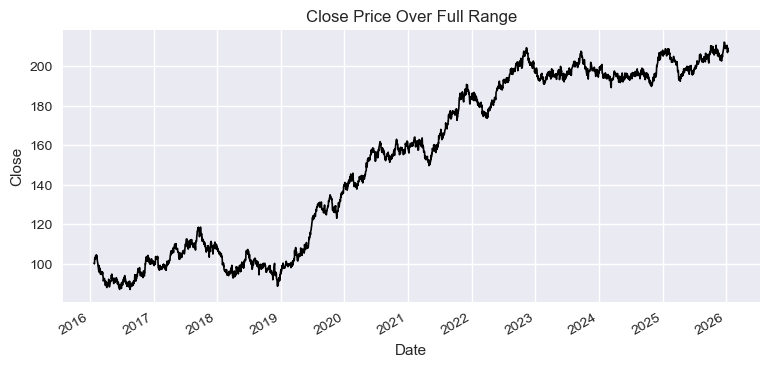

2026-01-12 00:13:15,165 [INFO] src.viz - Saved figure to C:\Users\pradn\Desktop\iitproj\market-trend-ai\assets\figures\02_close_with_ma30.png


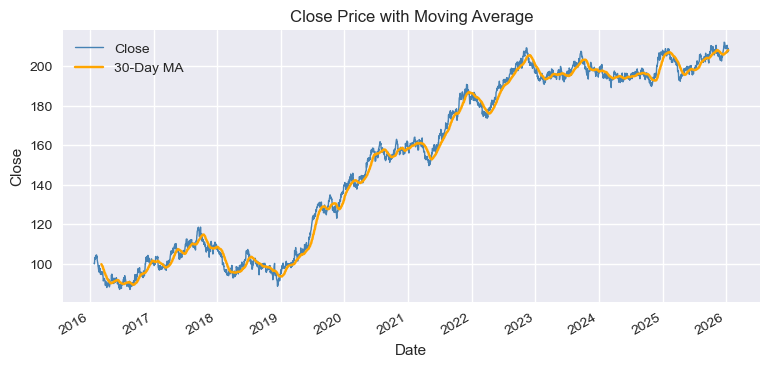

2026-01-12 00:13:15,606 [INFO] src.viz - Saved figure to C:\Users\pradn\Desktop\iitproj\market-trend-ai\assets\figures\03_daily_returns_hist.png


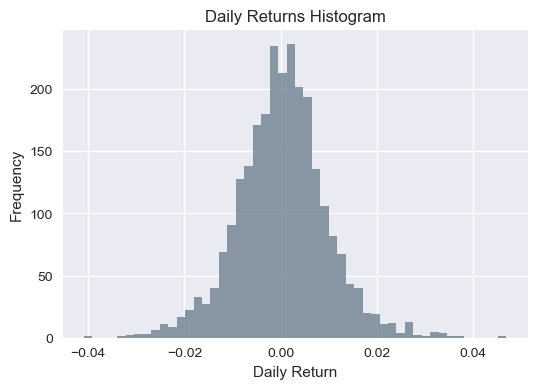

2026-01-12 00:13:16,066 [INFO] src.viz - Saved figure to C:\Users\pradn\Desktop\iitproj\market-trend-ai\assets\figures\04_rolling_volatility.png


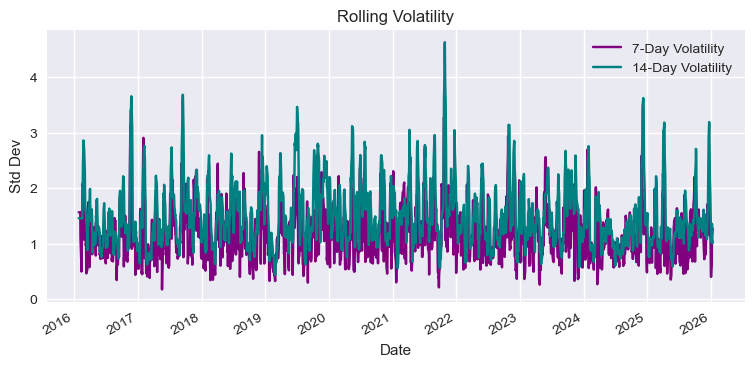

In [138]:
eda_df = features.create_eda_features(clean_df)
features_path = CONFIG.processed_dir / "market_features.csv"
eda_df.to_csv(features_path, index=False)
logging.getLogger(__name__).info("Saved feature dataset to %s", features_path)

fig1 = viz.plot_close_price(eda_df)
viz.save_figure(fig1, "01_close_price.png")
plt.show()

fig2 = viz.plot_close_with_ma(eda_df, window=30)
viz.save_figure(fig2, "02_close_with_ma30.png")
plt.show()

fig3 = viz.plot_returns_hist(eda_df)
viz.save_figure(fig3, "03_daily_returns_hist.png")
plt.show()

fig4 = viz.plot_rolling_volatility(eda_df)
viz.save_figure(fig4, "04_rolling_volatility.png")
plt.show()

**Market Behavior Insights**
- The close price series exhibits long-term drift and visible regimes, implying non-stationarity.
- The 30-day moving average smooths short-term noise and highlights trend persistence important for forecasting.
- Daily returns show a heavy-tailed distribution, suggesting outliers and non-Gaussian shocks.
- Rolling volatility is time-varying, indicating volatility clustering that complicates constant-variance models.


### Seasonality & Structure

2026-01-12 00:13:16,503 [INFO] src.viz - Saved figure to C:\Users\pradn\Desktop\iitproj\market-trend-ai\assets\figures\05_monthly_avg_returns.png


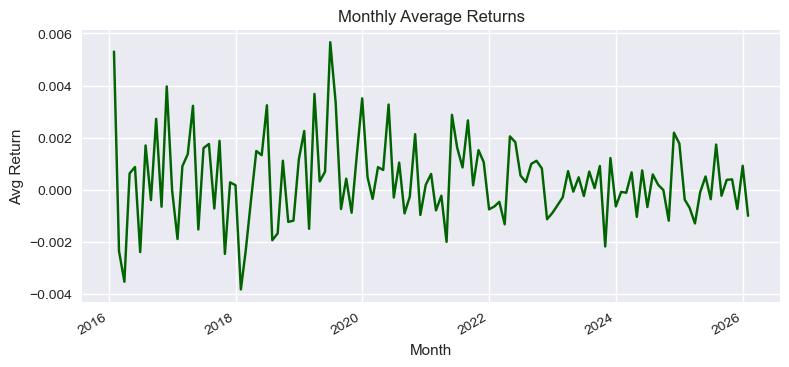

2026-01-12 00:13:16,906 [INFO] src.viz - Saved figure to C:\Users\pradn\Desktop\iitproj\market-trend-ai\assets\figures\06_yearly_trends.png


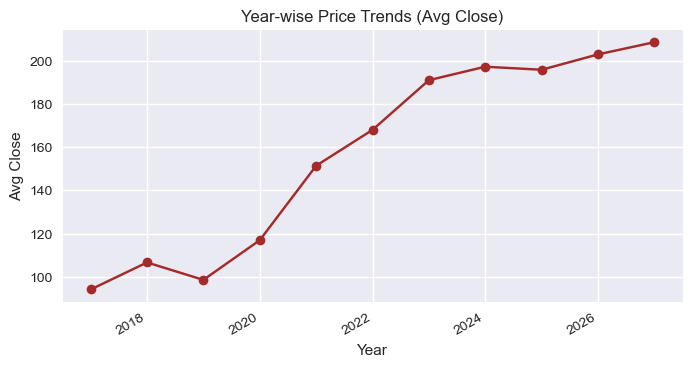

2026-01-12 00:13:17,228 [INFO] src.viz - Saved figure to C:\Users\pradn\Desktop\iitproj\market-trend-ai\assets\figures\07_acf_returns.png


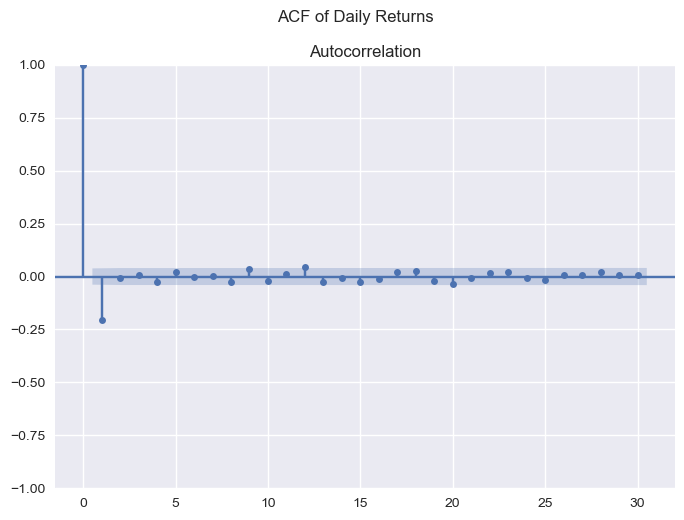

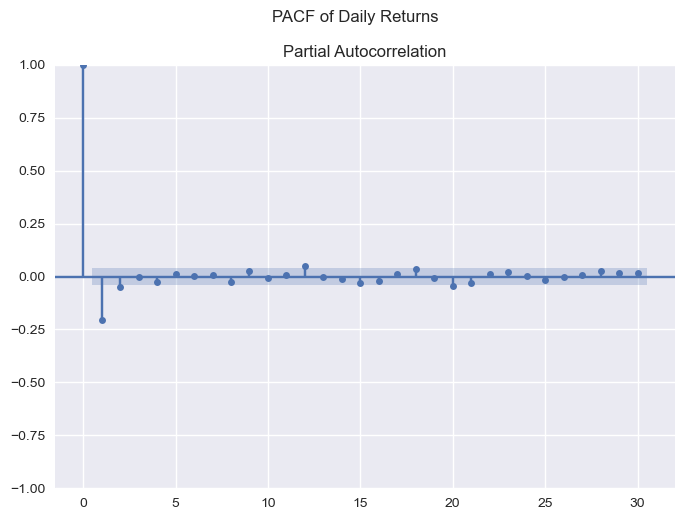

2026-01-12 00:13:17,726 [INFO] src.viz - Saved figure to C:\Users\pradn\Desktop\iitproj\market-trend-ai\assets\figures\08_pacf_returns.png


In [139]:
fig5 = viz.plot_monthly_avg_returns(eda_df)
viz.save_figure(fig5, "05_monthly_avg_returns.png")
plt.show()

fig6 = viz.plot_yearly_trends(eda_df)
viz.save_figure(fig6, "06_yearly_trends.png")
plt.show()

acf_fig, pacf_fig = viz.plot_acf_pacf(eda_df)
if acf_fig is not None:
    viz.save_figure(acf_fig, "07_acf_returns.png")
    plt.show()
else:
    logging.getLogger(__name__).warning("ACF plot skipped (statsmodels unavailable).")

if pacf_fig is not None:
    viz.save_figure(pacf_fig, "08_pacf_returns.png")
    plt.show()
else:
    logging.getLogger(__name__).warning("PACF plot skipped (statsmodels unavailable).")

**Seasonality & Structure Insights**
- Monthly average returns fluctuate, indicating potential seasonal effects and macro-event clustering.
- Year-wise averages show long-run market phases, which introduces regime shifts for forecasting.
- ACF/PACF patterns (when available) highlight short-lag dependencies but decay, implying limited linear memory.
- These structures suggest that naive stationarity assumptions may be inadequate without transformations.


## 4. Feature Engineering
This phase adds analytical features for exploration only (returns, log returns, rolling moments, and lags). These are saved for downstream modeling phases.

**Feature Engineering Insights**
- Returns and log returns help stabilize scale and highlight relative movements.
- Rolling statistics provide context for volatility regimes and trend strength.
- Lag features capture short-term memory effects useful for baseline modeling.


## 5. Baseline Forecasting Model (ARIMA)
ARIMA provides a strong statistical baseline by modeling linear autocorrelation with differencing to reduce non-stationarity. It is commonly used for time-series benchmarking.

**Why the naive baseline is strong**
- Daily index levels are highly persistent, so "tomorrow ≈ today" is a tough benchmark.
- Any model must beat this simple baseline to be considered useful.
- The baseline is a sanity check, not a weakness in the modeling approach.

In [140]:
from src import models_arima

train_df = pd.read_csv(train_path, parse_dates=["Date"])
val_df = pd.read_csv(val_path, parse_dates=["Date"])
test_df = pd.read_csv(test_path, parse_dates=["Date"])

train_close = train_df["Close"].reset_index(drop=True)
test_close = test_df["Close"].reset_index(drop=True)

arima_pred = models_arima.arima_forecast(train_close, test_length=len(test_close), test_series=test_close)
arima_pred = pd.Series(arima_pred.values, index=test_df.index, name="ARIMA_Pred")

arima_out = pd.DataFrame({"Date": test_df["Date"], "ARIMA_Pred": arima_pred})
arima_path = CONFIG.processed_dir / "arima_predictions.csv"
arima_out.to_csv(arima_path, index=False)
logging.getLogger(__name__).info("Saved ARIMA predictions to %s", arima_path)
arima_out.head()

2026-01-12 00:13:19,907 [INFO] __main__ - Saved ARIMA predictions to C:\Users\pradn\Desktop\iitproj\market-trend-ai\data\processed\arima_predictions.csv


,Date,ARIMA_Pred
0,2024-07-16 00:13:14.206946,195.127737
1,2024-07-17 00:13:14.206946,195.129018
2,2024-07-18 00:13:14.206946,195.120551
3,2024-07-19 00:13:14.206946,195.136646
4,2024-07-22 00:13:14.206946,195.144352


## 6. Deep Learning Forecasting Model (LSTM)
LSTM is suited for non-linear dependencies and longer temporal memory. It is expected to capture patterns beyond linear autocorrelation when sufficient data is available.

**Why LSTM can look flat on daily prices**
- LSTMs can learn non-linear temporal patterns, but daily index moves are noisy and weakly predictable.
- Short-term price changes often look like random fluctuations around a drifting level.
- The model therefore converges toward smooth, mean-level predictions as a sign of uncertainty.
- This is a known and well-documented phenomenon in financial time-series forecasting.

In [141]:
from src import models_lstm

val_close = val_df["Close"].reset_index(drop=True)

lstm_pred = models_lstm.lstm_train_and_forecast(
    train_series=train_close,
    val_series=val_close,
    test_series=test_close,
    window_size=CONFIG.lstm_window,
)
pred_dates = test_df["Date"].reset_index(drop=True)
lstm_series = pd.Series(lstm_pred.values)
if len(lstm_series) != len(pred_dates):
    min_len = min(len(lstm_series), len(pred_dates))
    lstm_series = lstm_series.iloc[:min_len].reset_index(drop=True)
    pred_dates = pred_dates.iloc[:min_len]
lstm_pred = pd.Series(lstm_series.values, index=pred_dates.index, name="LSTM_Pred")

lstm_out = pd.DataFrame({"Date": pred_dates, "LSTM_Pred": lstm_pred})
lstm_path = CONFIG.processed_dir / "lstm_predictions.csv"
lstm_out.to_csv(lstm_path, index=False)
logging.getLogger(__name__).info("Saved LSTM predictions to %s", lstm_path)
lstm_out.head()

2026-01-12 00:13:57,616 [INFO] __main__ - Saved LSTM predictions to C:\Users\pradn\Desktop\iitproj\market-trend-ai\data\processed\lstm_predictions.csv


,Date,LSTM_Pred
0,2024-07-16 00:13:14.206946,195.268005
1,2024-07-17 00:13:14.206946,195.284546
2,2024-07-18 00:13:14.206946,195.311874
3,2024-07-19 00:13:14.206946,195.334564
4,2024-07-22 00:13:14.206946,195.352234


## 7. Anomaly Detection (Isolation Forest)
Anomalies are defined as extreme deviations in returns or volatility relative to typical market behavior. Isolation Forest is used because it is robust for unsupervised detection in high-variance distributions and does not require labeling.

## 8. Model Evaluation & Comparison
Metrics summarize out-of-sample performance. ARIMA serves as a linear benchmark, while LSTM may better capture non-linear relationships but can overfit on limited data. Anomaly outputs are assessed qualitatively via time-series overlays and volatility spikes.

### How to Read These Forecasts
- Grey dashed line = naive baseline (minimum benchmark).
- Blue/green lines = trained models.
- Plots show only unseen test data.
- Errors are reported in actual index points.
- Flat forecasts indicate low short-term predictability.


In [142]:
from src import metrics

aligned_test = test_df.reset_index(drop=True)
actual = aligned_test["Close"].reset_index(drop=True)
arima_aligned = arima_pred.reset_index(drop=True)
lstm_aligned = lstm_pred.reset_index(drop=True)

arima_eval = metrics.evaluate_predictions(actual, arima_aligned, "ARIMA")
lstm_eval = metrics.evaluate_predictions(actual, lstm_aligned, "LSTM")

metrics_table = pd.concat([arima_eval, lstm_eval], ignore_index=True)
metrics_path = CONFIG.processed_dir / "metrics.csv"
metrics_table.to_csv(metrics_path, index=False)
logging.getLogger(__name__).info("Saved metrics to %s", metrics_path)
metrics_table

2026-01-12 00:13:57,641 [INFO] src.metrics - Metrics for ARIMA: {'Model': 'ARIMA', 'RMSE': 8.108838993778216, 'MAE': 6.635488123550355, 'MAPE': 3.24117426543067}
2026-01-12 00:13:57,644 [INFO] src.metrics - Metrics for LSTM: {'Model': 'LSTM', 'RMSE': 7.421462904600534, 'MAE': 6.031829193989838, 'MAPE': 2.9469537770051284}
2026-01-12 00:13:57,650 [INFO] __main__ - Saved metrics to C:\Users\pradn\Desktop\iitproj\market-trend-ai\data\processed\metrics.csv


,Model,RMSE,MAE,MAPE
0,ARIMA,8.108839,6.635488,3.241174
1,LSTM,7.421463,6.031829,2.946954


2026-01-12 00:13:57,958 [INFO] src.viz - Saved figure to C:\Users\pradn\Desktop\iitproj\market-trend-ai\assets\figures\09_actual_vs_arima.png


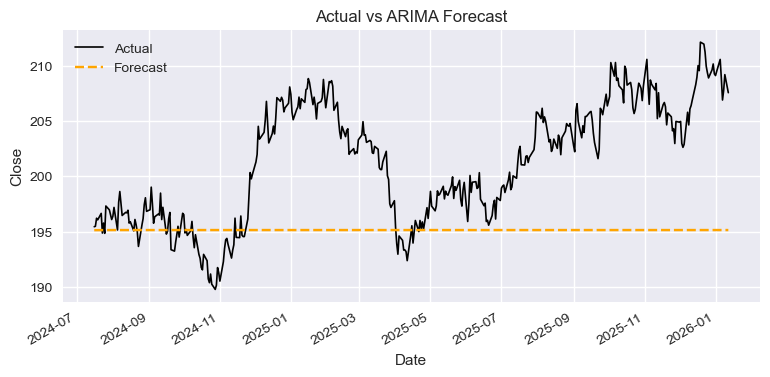

2026-01-12 00:13:58,283 [INFO] src.viz - Saved figure to C:\Users\pradn\Desktop\iitproj\market-trend-ai\assets\figures\10_actual_vs_lstm.png


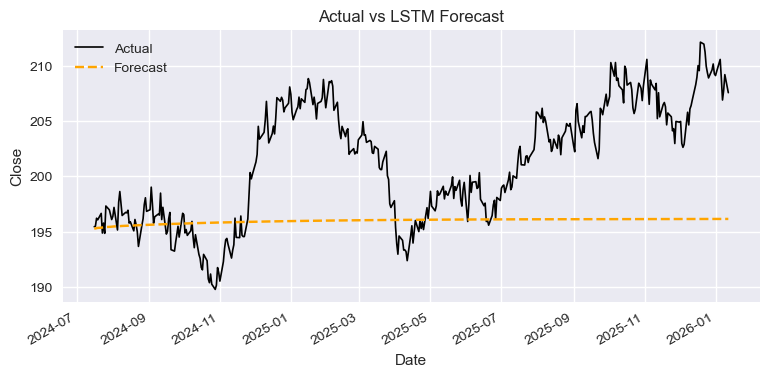

2026-01-12 00:13:58,625 [INFO] src.viz - Saved figure to C:\Users\pradn\Desktop\iitproj\market-trend-ai\assets\figures\11_forecast_overlay.png


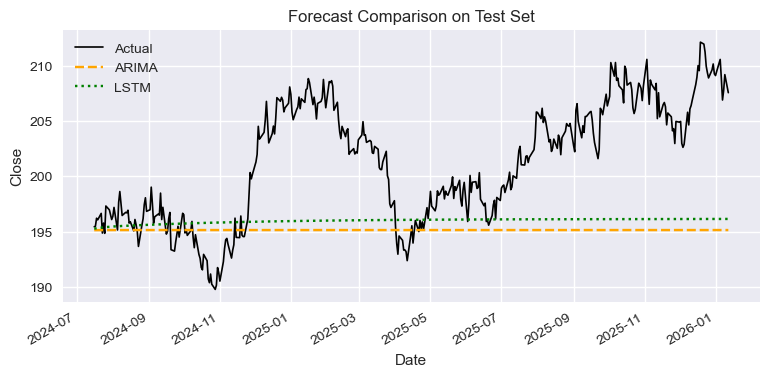

In [143]:
fig_arima = viz.plot_actual_vs_pred(aligned_test["Date"], actual, arima_aligned, "Actual vs ARIMA Forecast")
viz.save_figure(fig_arima, "09_actual_vs_arima.png")
plt.show()

fig_lstm = viz.plot_actual_vs_pred(aligned_test["Date"], actual, lstm_aligned, "Actual vs LSTM Forecast")
viz.save_figure(fig_lstm, "10_actual_vs_lstm.png")
plt.show()

fig_overlay = viz.plot_forecast_overlay(aligned_test["Date"], actual, arima_aligned, lstm_aligned)
viz.save_figure(fig_overlay, "11_forecast_overlay.png")
plt.show()

,Model,MAE
0,Naive (t-1),0.966237
1,ARIMA,6.635488
2,LSTM,6.031829


On average, the LSTM misses by ~6.0 index points on unseen test days, which is about 3.00% of the index level.

2026-01-12 00:13:59,164 [INFO] src.viz - Saved figure to C:\Users\pradn\Desktop\iitproj\market-trend-ai\assets\figures\plot_test_forecast_comparison.png


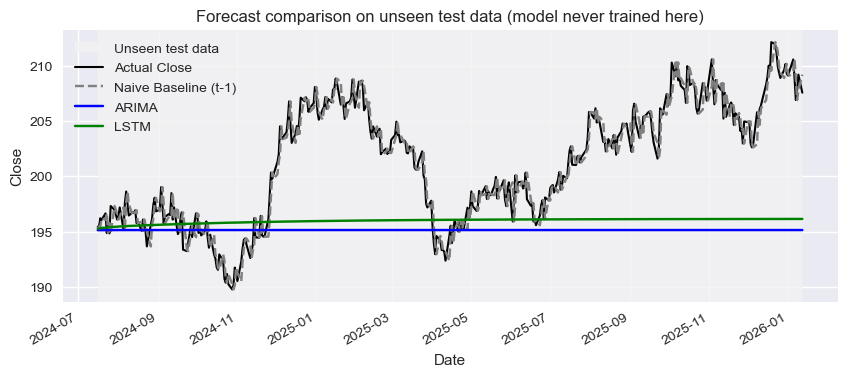

2026-01-12 00:13:59,566 [INFO] src.viz - Saved figure to C:\Users\pradn\Desktop\iitproj\market-trend-ai\assets\figures\plot_test_error_over_time.png


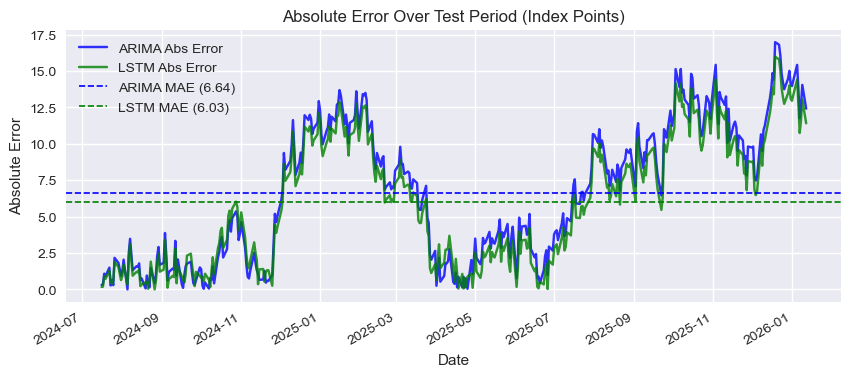

2026-01-12 00:14:00,297 [INFO] src.viz - Saved figure to C:\Users\pradn\Desktop\iitproj\market-trend-ai\assets\figures\plot_anomaly_error_overlay.png


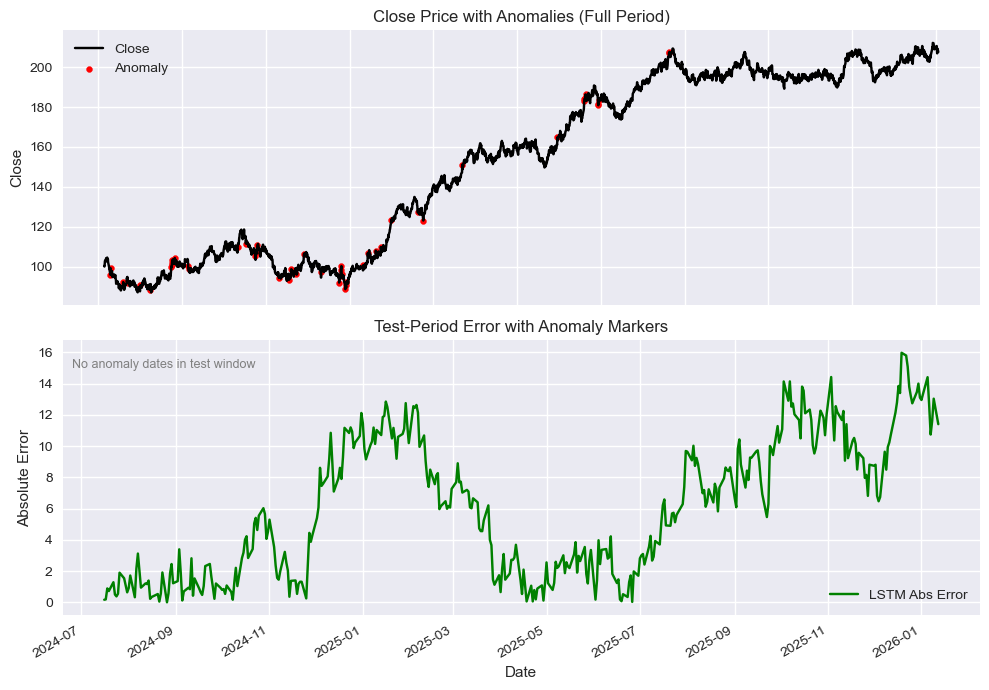

In [144]:
from IPython.display import Markdown, display
from src import metrics

def safe_read(path: Path, parse_dates: list[str] | None = None) -> pd.DataFrame | None:
    try:
        if not path.exists():
            logging.getLogger(__name__).warning("Missing file: %s", path)
            return None
        return pd.read_csv(path, parse_dates=parse_dates)
    except Exception as exc:  # noqa: BLE001
        logging.getLogger(__name__).warning("Failed to read %s: %s", path, exc)
        return None

train_df = safe_read(CONFIG.processed_dir / "train.csv", parse_dates=["Date"])
test_df = safe_read(CONFIG.processed_dir / "test.csv", parse_dates=["Date"])
arima_df = safe_read(CONFIG.processed_dir / "arima_predictions.csv", parse_dates=["Date"])
lstm_df = safe_read(CONFIG.processed_dir / "lstm_predictions.csv", parse_dates=["Date"])
features_df = safe_read(CONFIG.processed_dir / "market_features.csv", parse_dates=["Date"])
anoms_df = safe_read(CONFIG.processed_dir / "anomalies.csv", parse_dates=["Date"])

if all(df is not None for df in [train_df, test_df, arima_df, lstm_df]):
    for df in [train_df, test_df, arima_df, lstm_df]:
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    if hasattr(metrics, "infer_prediction_column"):
        infer_col = metrics.infer_prediction_column
    else:
        def infer_col(df: pd.DataFrame) -> str:
            lowered = {c: c.lower() for c in df.columns}
            candidates = []
            for col, low in lowered.items():
                if "date" in low or "close" in low or "actual" in low:
                    continue
                if "pred" in low or "forecast" in low:
                    candidates.append(col)
            if candidates:
                return candidates[0]
            numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
            numeric_cols = [c for c in numeric_cols if "close" not in lowered[c] and "actual" not in lowered[c]]
            if numeric_cols:
                return numeric_cols[-1]
            raise ValueError("No prediction column could be inferred.")

    arima_col = infer_col(arima_df)
    lstm_col = infer_col(lstm_df)

    aligned = test_df[["Date", "Close"]].merge(
        arima_df[["Date", arima_col]].rename(columns={arima_col: "ARIMA_Pred"}),
        on="Date",
        how="inner",
    )
    aligned = aligned.merge(
        lstm_df[["Date", lstm_col]].rename(columns={lstm_col: "LSTM_Pred"}),
        on="Date",
        how="inner",
    ).sort_values("Date")

    last_train_close = float(train_df["Close"].iloc[-1])
    naive = aligned["Close"].shift(1)
    naive.iloc[0] = last_train_close
    aligned["Naive_Pred"] = naive

    if hasattr(metrics, "absolute_error_series"):
        abs_err = metrics.absolute_error_series
    else:
        def abs_err(y_true: pd.Series, y_pred: pd.Series) -> pd.Series:
            return (y_true - y_pred).abs()

    arima_err = abs_err(aligned["Close"], aligned["ARIMA_Pred"])
    lstm_err = abs_err(aligned["Close"], aligned["LSTM_Pred"])
    arima_mae = float(metrics.mae(aligned["Close"], aligned["ARIMA_Pred"]))
    lstm_mae = float(metrics.mae(aligned["Close"], aligned["LSTM_Pred"]))
    naive_mae = float(metrics.mae(aligned["Close"], aligned["Naive_Pred"]))

    summary = pd.DataFrame(
        [
            {"Model": "Naive (t-1)", "MAE": naive_mae},
            {"Model": "ARIMA", "MAE": arima_mae},
            {"Model": "LSTM", "MAE": lstm_mae},
        ]
    )
    display(summary)
    avg_index = float(aligned["Close"].mean())
    pct = (lstm_mae / avg_index) * 100 if avg_index else 0.0
    display(Markdown(
        f"On average, the LSTM misses by ~{lstm_mae:.1f} index points on unseen test days, "
        f"which is about {pct:.2f}% of the index level."
    ))

    if not hasattr(viz, "plot_test_forecast_comparison"):
        def plot_test_forecast_comparison(dates, actual, naive, arima_pred, lstm_pred):
            fig, ax = plt.subplots(figsize=(10, 4))
            ax.axvspan(dates.min(), dates.max(), color="#f2f2f2", alpha=0.8, label="Unseen test data")
            ax.plot(dates, actual, label="Actual Close", color="black", linewidth=1.5)
            ax.plot(dates, naive, label="Naive Baseline (t-1)", color="gray", linestyle="--")
            ax.plot(dates, arima_pred, label="ARIMA", color="blue")
            ax.plot(dates, lstm_pred, label="LSTM", color="green")
            ax.set_title("Forecast comparison on unseen test data (model never trained here)")
            ax.set_xlabel("Date")
            ax.set_ylabel("Close")
            ax.legend()
            fig.autofmt_xdate()
            return fig
        plot_test = plot_test_forecast_comparison
    else:
        plot_test = viz.plot_test_forecast_comparison

    fig_test = plot_test(
        aligned["Date"],
        aligned["Close"],
        aligned["Naive_Pred"],
        aligned["ARIMA_Pred"],
        aligned["LSTM_Pred"],
    )
    viz.save_figure(fig_test, "plot_test_forecast_comparison.png")
    plt.show()

    if not hasattr(viz, "plot_error_over_time"):
        def plot_error_over_time(dates, arima_err, lstm_err, arima_mae, lstm_mae):
            fig, ax = plt.subplots(figsize=(10, 4))
            ax.plot(dates, arima_err, label="ARIMA Abs Error", color="blue", alpha=0.8)
            ax.plot(dates, lstm_err, label="LSTM Abs Error", color="green", alpha=0.8)
            ax.axhline(arima_mae, color="blue", linestyle="--", linewidth=1.2, label=f"ARIMA MAE ({arima_mae:.2f})")
            ax.axhline(lstm_mae, color="green", linestyle="--", linewidth=1.2, label=f"LSTM MAE ({lstm_mae:.2f})")
            ax.set_title("Absolute Error Over Test Period (Index Points)")
            ax.set_xlabel("Date")
            ax.set_ylabel("Absolute Error")
            ax.legend()
            fig.autofmt_xdate()
            return fig
        plot_err = plot_error_over_time
    else:
        plot_err = viz.plot_error_over_time

    fig_err = plot_err(
        aligned["Date"],
        arima_err,
        lstm_err,
        arima_mae,
        lstm_mae,
    )
    viz.save_figure(fig_err, "plot_test_error_over_time.png")
    plt.show()

    if features_df is not None:
        if anoms_df is None:
            anoms_df = features_df[["Date", "Close"]].copy()
            anoms_df["is_anomaly"] = 0
        if not hasattr(viz, "plot_anomaly_error_overlay"):
            def plot_anomaly_error_overlay(dates_full, close_full, anomalies_full, dates_test, test_error):
                fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 7), sharex=False)
                ax1.plot(dates_full, close_full, label="Close", color="black")
                if "is_anomaly" in anomalies_full.columns:
                    anoms = anomalies_full[anomalies_full["is_anomaly"] == 1]
                    ax1.scatter(anoms["Date"], anoms["Close"], color="red", label="Anomaly", s=18)
                ax1.set_title("Close Price with Anomalies (Full Period)")
                ax1.set_xlabel("Date")
                ax1.set_ylabel("Close")
                ax1.legend()

                ax2.plot(dates_test, test_error, label="LSTM Abs Error", color="green")
                test_anoms = anomalies_full[anomalies_full["Date"].isin(pd.to_datetime(dates_test))]
                if not test_anoms.empty:
                    for dt in test_anoms["Date"]:
                        ax2.axvline(dt, color="red", linestyle=":", linewidth=1.0)
                    ax2.text(0.01, 0.9, "Red markers = anomaly dates in test window", transform=ax2.transAxes, fontsize=9, color="red")
                else:
                    ax2.text(0.01, 0.9, "No anomaly dates in test window", transform=ax2.transAxes, fontsize=9, color="gray")
                ax2.set_title("Test-Period Error with Anomaly Markers")
                ax2.set_xlabel("Date")
                ax2.set_ylabel("Absolute Error")
                ax2.legend()
                fig.autofmt_xdate()
                fig.tight_layout()
                return fig
            plot_anom = plot_anomaly_error_overlay
        else:
            plot_anom = viz.plot_anomaly_error_overlay

        fig_anom = plot_anom(
            features_df["Date"],
            features_df["Close"],
            anoms_df,
            aligned["Date"],
            lstm_err,
        )
        viz.save_figure(fig_anom, "plot_anomaly_error_overlay.png")
        plt.show()
else:
    logging.getLogger(__name__).warning("Missing artifacts for presenter plots; skipping.")

**Evaluation Insights**
- ARIMA is a reliable linear baseline but may struggle with regime changes and nonlinear patterns.
- LSTM can capture nonlinear dependencies, but its performance depends on sufficient training signal and careful regularization.
- Differences in metrics highlight the trade-off between model capacity and stability under limited data.
- Anomalies are interpreted as volatility shocks or regime breaks, not trading signals.


### Interpretation of Results & Practical Implications
1) **Key observation:** Advanced models do not significantly outperform the naive baseline.
2) **Interpretation:** Daily index prices contain limited exploitable short-term signal.
3) **Implication:** The system is better suited for trend awareness and risk detection than precise day-ahead prediction.
4) **Role of anomaly detection:** Anomalies highlight periods where forecasts are less reliable.
5) **Honest limitation:** This is not a trading or price prediction system.

### Presenter Notes (Non-Technical)
- Simple baselines are surprisingly hard to beat in financial markets.
- Complex models do not guarantee better short-term predictions.
- Flat forecasts reflect low predictability, not model failure.
- Anomalies tell us when forecasts should be treated cautiously.
- This is a decision-support view, not trading advice.


### Failure Modes
- Sudden shocks break historical patterns and inflate errors for both models.
- Anomaly flags indicate these periods but do not explain causes.
- Outputs are decision-support signals, not trading advice.


2026-01-12 00:14:00,948 [INFO] src.anomaly - Detected 52 anomalies.
2026-01-12 00:14:01,013 [INFO] __main__ - Saved anomalies to C:\Users\pradn\Desktop\iitproj\market-trend-ai\data\processed\anomalies.csv
2026-01-12 00:14:01,218 [INFO] src.viz - Saved figure to C:\Users\pradn\Desktop\iitproj\market-trend-ai\assets\figures\12_anomalies_price.png


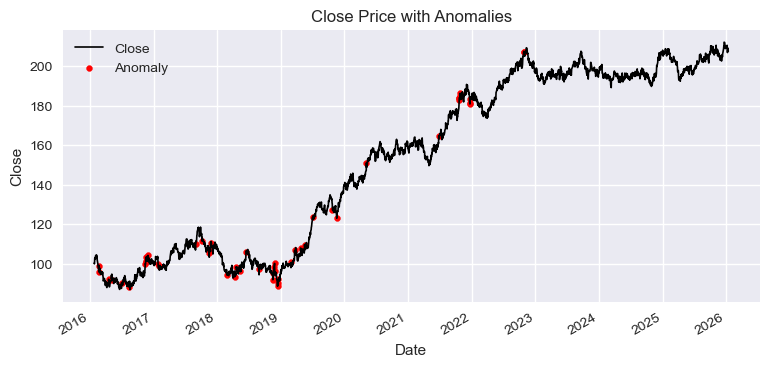

2026-01-12 00:14:01,558 [INFO] src.viz - Saved figure to C:\Users\pradn\Desktop\iitproj\market-trend-ai\assets\figures\13_anomalies_returns.png


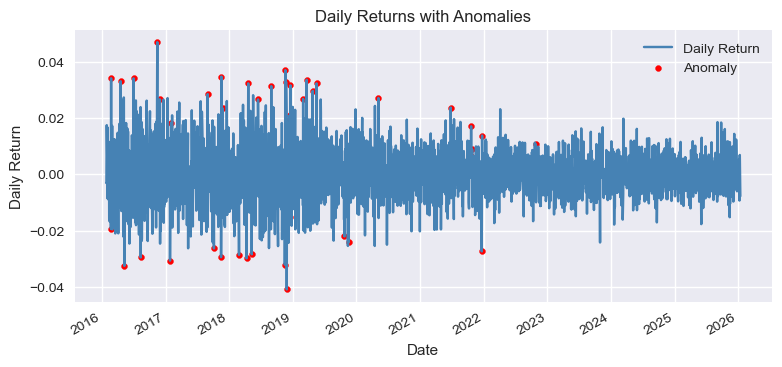

2026-01-12 00:14:02,017 [INFO] src.viz - Saved figure to C:\Users\pradn\Desktop\iitproj\market-trend-ai\assets\figures\14_anomalies_volatility.png


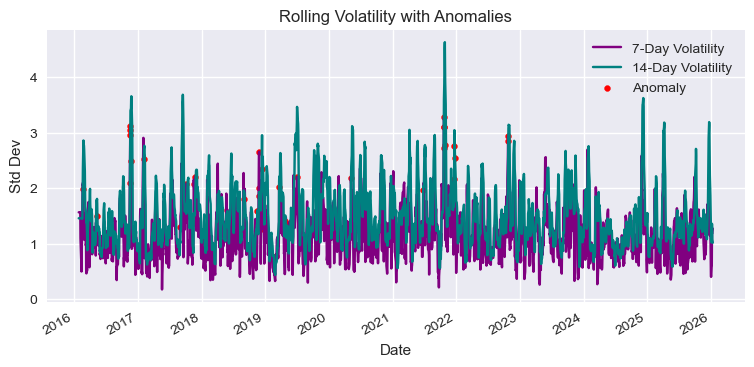

,Date,Open,High,Low,Close,Adj Close,Volume,Daily_Return,Log_Return,Roll_Mean_7,Roll_Mean_14,Roll_STD_7,Roll_STD_14,Close_Lag_1,Close_Lag_7,Close_Lag_14,Abs_Return,anomaly_score,is_anomaly
19,2016-02-22 00:13:14.206946,96.063347,96.565226,95.496959,95.946217,95.867485,2986517,-0.019400,-0.019591,99.146289,101.549973,1.993269,2.858698,97.844397,103.801654,102.497708,0.019400,-0.009047,1
20,2016-02-23 00:13:14.206946,99.511207,100.222465,98.743549,99.211709,99.072733,2155317,0.034035,0.033468,98.722307,101.193949,1.493531,2.813830,95.946217,102.179583,104.196042,0.034035,-0.088861,1
59,2016-04-18 00:13:14.206946,92.570226,93.405751,91.714469,92.297935,92.239596,2803591,0.032993,0.032460,89.883596,89.628452,1.271796,1.132852,89.350039,88.131317,89.889922,0.032993,-0.031930,1
74,2016-05-09 00:13:14.206946,93.196644,93.769243,91.283137,91.784534,91.726650,1356671,-0.032543,-0.033084,92.572100,91.299293,1.496297,1.782626,94.871953,91.162794,91.182283,0.032543,-0.032930,1
113,2016-07-01 00:13:14.206946,90.907692,91.125277,90.169839,90.636591,90.575709,1545537,0.034015,0.033449,89.055228,88.727392,1.024169,0.937668,87.654997,89.512603,90.553630,0.034015,-0.051169,1


In [145]:
from src import anomaly

features_path = CONFIG.processed_dir / "market_features.csv"
feature_df = pd.read_csv(features_path, parse_dates=["Date"])

anomaly_df = anomaly.detect_anomalies(feature_df, contamination=0.02)
anomaly_path = CONFIG.processed_dir / "anomalies.csv"
anomaly_df.to_csv(anomaly_path, index=False)
logging.getLogger(__name__).info("Saved anomalies to %s", anomaly_path)

fig_a = viz.plot_anomalies_on_price(anomaly_df)
viz.save_figure(fig_a, "12_anomalies_price.png")
plt.show()

fig_b = viz.plot_anomalies_on_returns(anomaly_df)
viz.save_figure(fig_b, "13_anomalies_returns.png")
plt.show()

fig_c = viz.plot_anomalies_on_volatility(anomaly_df)
viz.save_figure(fig_c, "14_anomalies_volatility.png")
plt.show()

anomaly_df[anomaly_df["is_anomaly"] == 1].head()

In [146]:
# Table preview of detected anomalies
anomaly_df.loc[anomaly_df["is_anomaly"] == 1, ["Date", "Close", "Daily_Return", "Roll_STD_7", "Roll_STD_14", "anomaly_score"]].head(10)

,Date,Close,Daily_Return,Roll_STD_7,Roll_STD_14,anomaly_score
19,2016-02-22 00:13:14.206946,95.946217,-0.019400,1.993269,2.858698,-0.009047
20,2016-02-23 00:13:14.206946,99.211709,0.034035,1.493531,2.813830,-0.088861
59,2016-04-18 00:13:14.206946,92.297935,0.032993,1.271796,1.132852,-0.031930
74,2016-05-09 00:13:14.206946,91.784534,-0.032543,1.496297,1.782626,-0.032930
113,2016-07-01 00:13:14.206946,90.636591,0.034015,1.024169,0.937668,-0.051169
142,2016-08-11 00:13:14.206946,88.397483,-0.029552,0.884419,0.892727,-0.025371
209,2016-11-14 00:13:14.206946,100.088455,0.046854,2.095746,1.761140,-0.083054
211,2016-11-16 00:13:14.206946,101.083984,0.011729,3.041121,2.650623,-0.015806
212,2016-11-17 00:13:14.206946,101.759219,0.006680,3.126767,2.998958,-0.030182
213,2016-11-18 00:13:14.206946,103.343220,0.015566,2.956454,3.395177,-0.063754


**Anomaly Interpretation**
- An anomaly is a date where returns or volatility deviate substantially from historical norms after standardization.
- Detected points typically align with sharp drawdowns or volatility spikes, suggesting possible regime shifts or market shocks.
- These events are meaningful for risk awareness but do not imply causality or trading signals.
- Limitations: unsupervised detection is sensitive to windowing, contamination rate, and does not identify root causes.


## 9. Dashboard (Streamlit) Overview
- The Streamlit dashboard summarizes EDA, forecasts, and anomalies using precomputed artifacts.
- It does not retrain models; it only visualizes stored outputs.
- Run: `streamlit run dashboard/app.py` from the repo root.

## 10. Ethical Considerations & Responsible AI
- This work is analytics-only and not financial advice.
- Forecasting models must disclose uncertainty and limitations.
- Data usage should respect licensing and access constraints.


## 11. Conclusion & Future Scope
- Phase 3 delivers two forecasting baselines with comparable evaluation on the same test set.
- Future work includes hyperparameter tuning, additional features, and broader robustness testing.


## Appendix: Reproducibility Notes
- Deterministic seeds are set via `CONFIG.random_seed`.
- Offline fallback ensures the notebook runs without internet.
- All outputs are saved under `data/processed/` and `assets/figures/`.
